In [1]:
import sys
sys.path.insert(0, '/home/ldoyle/packages')
import h5py
import numpy as np
from tqdm import tqdm
import matplotlib
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pandas as pd
import pysindy as ps
from lr_ed import localreg
from datetime import datetime
from scipy.fft import fft, fftfreq,rfft2

import scipy.signal as signal
from obspy.signal import filter as obsfilt
import glob
from matplotlib import ticker


In [26]:
path = "/data/data2/south-data-ejm/hdd/South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-01T16_09_15-0700/"

fileStr = "2021-11-01T2311_unfiltered"

init = 11
final= 16

time_subsample = 10
full_dat = np.zeros((5000,(12000//time_subsample)*(final-init)))

k = 0
for i in np.arange(init,final):
    file = "South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-01T23"+str(i)+"14Z.h5"
    f = h5py.File(path+file, 'r')
    data = f['Acquisition']['Raw[0]']['RawData'][:, :].astype('int64')
#     timestamp = f['Acquisition']['Raw[0]']['RawDataTime'][:] / 1000000
    f.close()
    
    full_dat[:,k*(12000//time_subsample):(k+1)*(12000//time_subsample)] = data[7500:12500,::time_subsample]
    k+=1
    
working_dat = full_dat/np.std(full_dat)


In [46]:
# working_dat = np.load("/home/ldoyle/notebooks/channel_drift_5_min_clips/normalized_5_min_start_South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-01T231114Z.npy")[:,::10]
working_dat = np.load("/home/ldoyle/notebooks/channel_drift_5_min_clips/rad_4_smoothed_decimated_normalized_5_min_start_South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-01T232114Z.npy")
# working_dat = np.load("/home/ldoyle/notebooks/channel_drift_5_min_clips/rad_10_smoothed_decimated_normalized_5_min_start_South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-01T231114Z.npy")


scaler_val = np.std(working_dat)
working_dat = working_dat/scaler_val
# working_dat = working_dat.reshape(working_dat.shape[0],working_dat.shape[1],1)

In [47]:
dt=1.
dx = 1.

In [48]:
windw = 40
# # differ = ps.differentiation.SmoothedFiniteDifference()
ut = ps.differentiation.SmoothedFiniteDifference(d=1, axis=1,order=4,is_uniform=True,
                         drop_endpoints=True, periodic=False,smoother_kws={'window_length': windw})._differentiate(working_dat, dt)
ux = ps.differentiation.SmoothedFiniteDifference(d=1, axis=0,order=4,is_uniform=True,
                         drop_endpoints=True, periodic=False,smoother_kws={'window_length': windw})._differentiate(working_dat, dx)
uxx = ps.differentiation.SmoothedFiniteDifference(d=2, axis=0,order=4,is_uniform=True,
                         drop_endpoints=True, periodic=False,smoother_kws={'window_length': windw})._differentiate(working_dat, dx)
uxxx = ps.differentiation.SmoothedFiniteDifference(d=3, axis=0,order=4,is_uniform=True,
                         drop_endpoints=True, periodic=False,smoother_kws={'window_length': windw})._differentiate(working_dat, dx)
uxxxx = ps.differentiation.SmoothedFiniteDifference(d=4, axis=0,order=4,is_uniform=True,
                         drop_endpoints=True, periodic=False,smoother_kws={'window_length': windw})._differentiate(working_dat, dx)

In [49]:
ux2 = ps.differentiation.SmoothedFiniteDifference(d=1, axis=0,order=4,is_uniform=True,
                         drop_endpoints=True, periodic=False,smoother_kws={'window_length': 30})._differentiate(working_dat, dx)
uxxx2 = ps.differentiation.SmoothedFiniteDifference(d=3, axis=0,order=4,is_uniform=True,
                         drop_endpoints=True, periodic=False,smoother_kws={'window_length': 30})._differentiate(working_dat, dx)

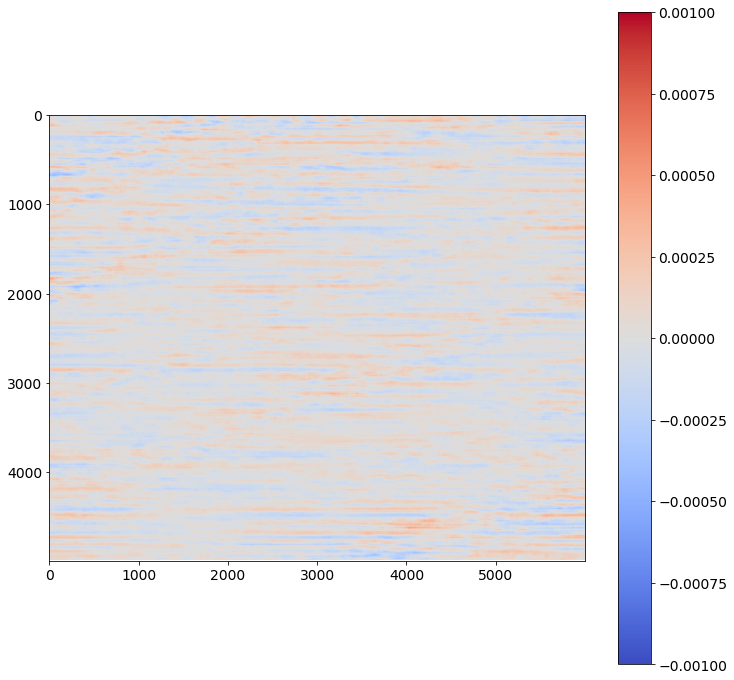

In [55]:
plt.figure(figsize=(12,12))
plt.imshow(uxxx - uxxx2, cmap="coolwarm",vmin=-0.001,vmax=0.001)
plt.colorbar()
plt.show()

In [24]:
# dudt = 0.6369*ux  + 0.3017 * uxxx  -0.0161  *(working_dat**2) * ux  + -0.0070 * (working_dat**2) *uxxx # the GOODIE

#choppy
# dudt = 0.645245 *ux + 0.360646 *uxxx

# normalized
# dudt = 0.680039 *ux + 0.319574 *uxxx
# dudt = 0.679112 *ux + 0.319926 *uxxx  -0.006064 * (working_dat**2) *ux
dudt = 0.679615 *ux + 0.318684 *uxxx  -0.007691 * (working_dat**2) *ux -0.003128 * (working_dat**2) *uxxx

#smoothed
# dudt = 0.996577 *ux
# dudt = 0.996861 *ux + 0.122231 *uxxx
# dudt = 0.997363 *ux + 0.100087 *uxxx + 0.061086 * (working_dat**2) *uxxx
# dudt = 0.995884 *ux + 0.098516 *uxxx + 0.001537 * (working_dat**2) *ux + 0.068080 * (working_dat**2) *uxxx



# dudt = 0.5116 *ux + 0.0066 *uxx + 0.2468 *uxxx  -0.0307 * (working_dat**2) *ux
# dudt = 0.1067 *ux + 0.0654 *uxxx

# dudt = 0.996577*ux
print("Percent diff.: "+str(np.nanmean(np.abs(dudt-ut))/np.nanmean(np.abs(ut))))


Percent diff.: 0.32095112057962943


## Compare $u_t$ to models visually

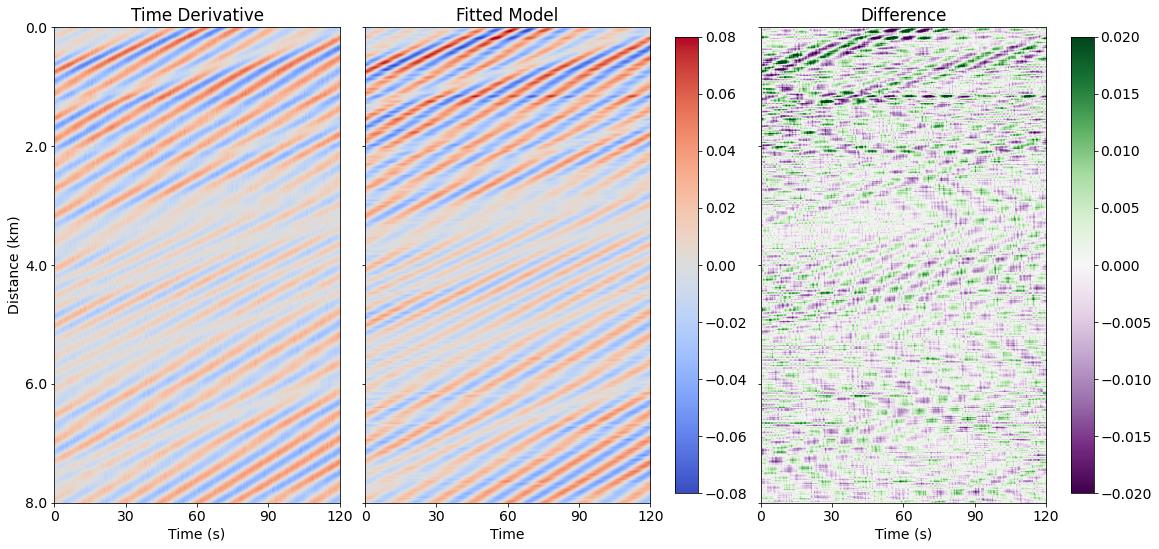

In [20]:
# data2 = ((2*np.pi)/2**16)*((1550.12 * 1e-9)/(0.78 * 4 * np.pi * n * L))*data[7500:12500,:]*1e6
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(nrows=1, ncols=3,figsize = (16, 12),sharey=True, layout='constrained')
ax0 = ax[0].imshow(ut[:4000,:2400],vmin=-0.08,vmax=0.08,cmap="coolwarm")
ax1 = ax[1].imshow(dudt[:4000,:2400],vmin=-0.08,vmax=0.08, cmap="coolwarm")
ax2 = ax[2].imshow((dudt-ut)[:4000,:2400], vmin=-0.02,vmax=0.02,cmap="PRGn")

ax[0].set_yticks(np.linspace(0, 4000, 5),
            (2/1000)*np.linspace(0, 4000, 5))
ax[0].set_xticks(np.linspace(0,2400,5),((10/200)*np.linspace(0,2400,5)).astype(int))
# ax[0].xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.0f}"))

ax[0].set_title('Time Derivative')
ax[0].set_xlabel("Time (s)",size=14)
ax[0].set_ylabel("Distance (km)",size=14)
ax[1].set_xticks(np.linspace(0,2400,5),((10/200)*np.linspace(0,2400,5)).astype(int))
# ax[1].xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.0f}"))
ax[1].set_title('Fitted Model')
ax[1].set_xlabel("Time",size=14)
fig.colorbar(ax1, ax=ax[1], location='right', fraction=0.08,pad=0.04)
ax[2].set_title('Difference')
ax[2].set_xlabel("Time (s)",size=14)
ax[2].set_xticks(np.linspace(0,2400,5),((10/200)*np.linspace(0,2400,5)).astype(int))
# ax[2].xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.0f}"))

fig.colorbar(ax2, ax=ax[2], location='right', fraction=0.08,pad=0.04)

plt.show()

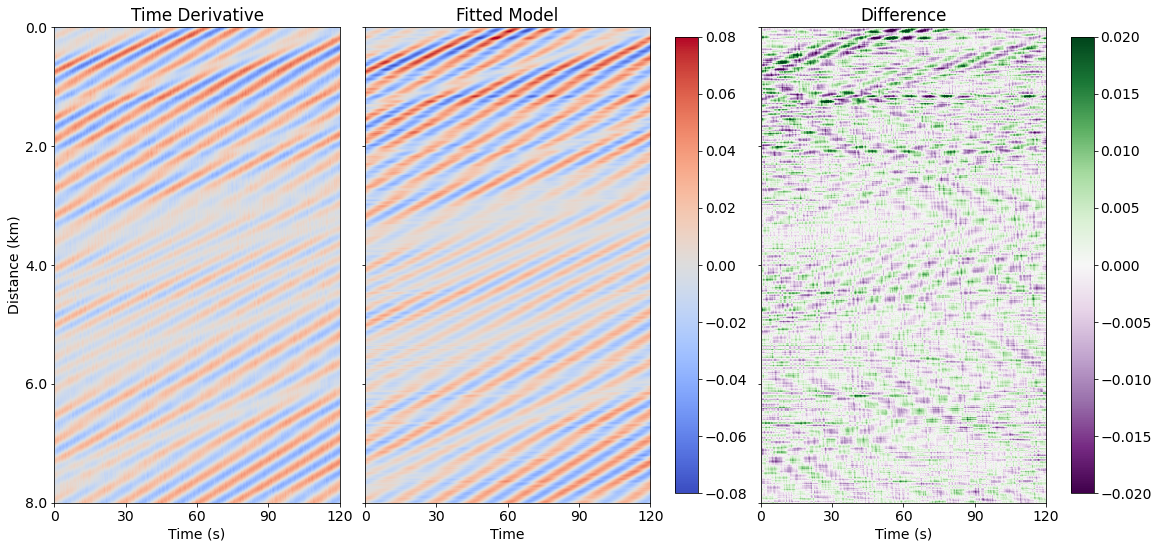

In [22]:
# data2 = ((2*np.pi)/2**16)*((1550.12 * 1e-9)/(0.78 * 4 * np.pi * n * L))*data[7500:12500,:]*1e6
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(nrows=1, ncols=3,figsize = (16, 12),sharey=True, layout='constrained')
ax0 = ax[0].imshow(ut[:4000,:2400],vmin=-0.08,vmax=0.08,cmap="coolwarm")
ax1 = ax[1].imshow(dudt[:4000,:2400],vmin=-0.08,vmax=0.08, cmap="coolwarm")
ax2 = ax[2].imshow((dudt-ut)[:4000,:2400], vmin=-0.02,vmax=0.02,cmap="PRGn")

ax[0].set_yticks(np.linspace(0, 4000, 5),
            (2/1000)*np.linspace(0, 4000, 5))
ax[0].set_xticks(np.linspace(0,2400,5),((10/200)*np.linspace(0,2400,5)).astype(int))
# ax[0].xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.0f}"))

ax[0].set_title('Time Derivative')
ax[0].set_xlabel("Time (s)",size=14)
ax[0].set_ylabel("Distance (km)",size=14)
ax[1].set_xticks(np.linspace(0,2400,5),((10/200)*np.linspace(0,2400,5)).astype(int))
# ax[1].xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.0f}"))
ax[1].set_title('Fitted Model')
ax[1].set_xlabel("Time",size=14)
fig.colorbar(ax1, ax=ax[1], location='right', fraction=0.08,pad=0.04)
ax[2].set_title('Difference')
ax[2].set_xlabel("Time (s)",size=14)
ax[2].set_xticks(np.linspace(0,2400,5),((10/200)*np.linspace(0,2400,5)).astype(int))
# ax[2].xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.0f}"))

fig.colorbar(ax2, ax=ax[2], location='right', fraction=0.08,pad=0.04)

plt.show()

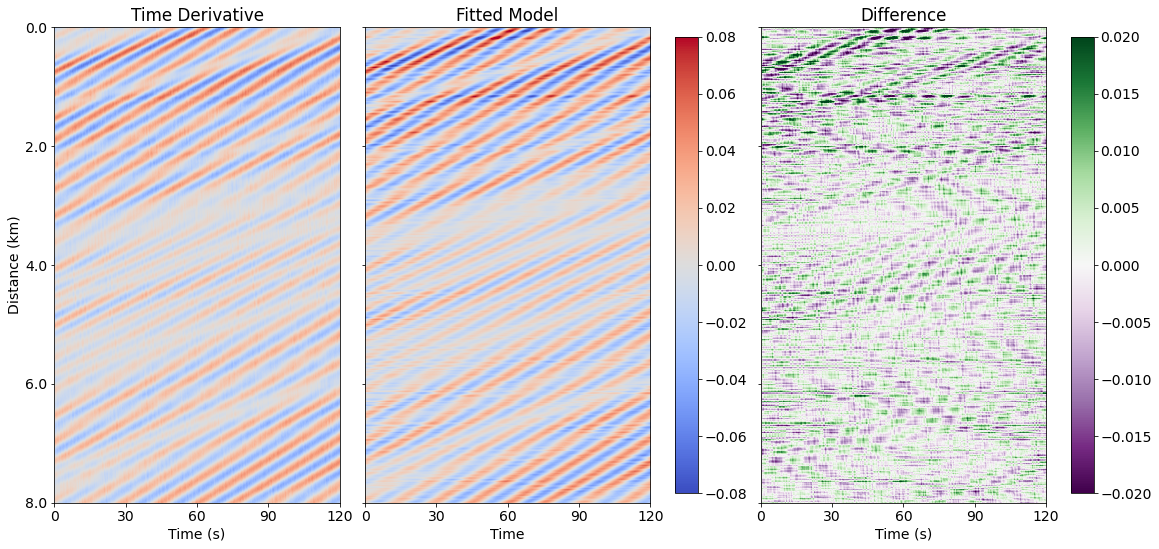

In [25]:
# data2 = ((2*np.pi)/2**16)*((1550.12 * 1e-9)/(0.78 * 4 * np.pi * n * L))*data[7500:12500,:]*1e6
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(nrows=1, ncols=3,figsize = (16, 12),sharey=True, layout='constrained')
ax0 = ax[0].imshow(ut[:4000,:2400],vmin=-0.08,vmax=0.08,cmap="coolwarm")
ax1 = ax[1].imshow(dudt[:4000,:2400],vmin=-0.08,vmax=0.08, cmap="coolwarm")
ax2 = ax[2].imshow((dudt-ut)[:4000,:2400], vmin=-0.02,vmax=0.02,cmap="PRGn")

ax[0].set_yticks(np.linspace(0, 4000, 5),
            (2/1000)*np.linspace(0, 4000, 5))
ax[0].set_xticks(np.linspace(0,2400,5),((10/200)*np.linspace(0,2400,5)).astype(int))
# ax[0].xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.0f}"))

ax[0].set_title('Time Derivative')
ax[0].set_xlabel("Time (s)",size=14)
ax[0].set_ylabel("Distance (km)",size=14)
ax[1].set_xticks(np.linspace(0,2400,5),((10/200)*np.linspace(0,2400,5)).astype(int))
# ax[1].xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.0f}"))
ax[1].set_title('Fitted Model')
ax[1].set_xlabel("Time",size=14)
fig.colorbar(ax1, ax=ax[1], location='right', fraction=0.08,pad=0.04)
ax[2].set_title('Difference')
ax[2].set_xlabel("Time (s)",size=14)
ax[2].set_xticks(np.linspace(0,2400,5),((10/200)*np.linspace(0,2400,5)).astype(int))
# ax[2].xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.0f}"))

fig.colorbar(ax2, ax=ax[2], location='right', fraction=0.08,pad=0.04)

plt.show()

In [10]:
print(np.mean(np.abs(uxxx )))
print(np.mean(np.abs(ux )))
print(np.mean(np.abs(ux - 70*uxxx)))

0.0006546583520720897
0.027215470309997502
0.058272970240787564


### $u^2 u_x $ vs. $ u^2 u_{xxx}$

In [14]:
print(np.mean(np.abs(uxxx ))/np.mean(np.abs(ut )))

0.012430616050839378


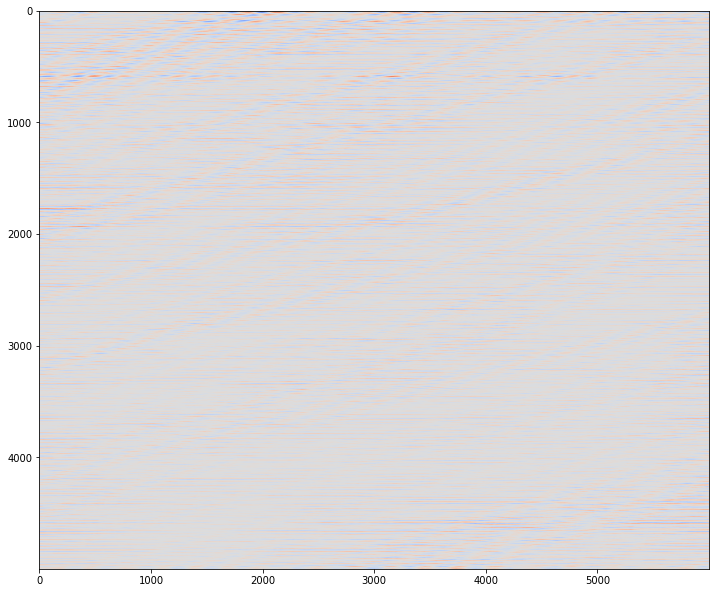

In [21]:
plt.figure(figsize=(12,12))
plt.imshow(uxxx ,vmin=-0.002,vmax=0.002,cmap="coolwarm")
plt.show()

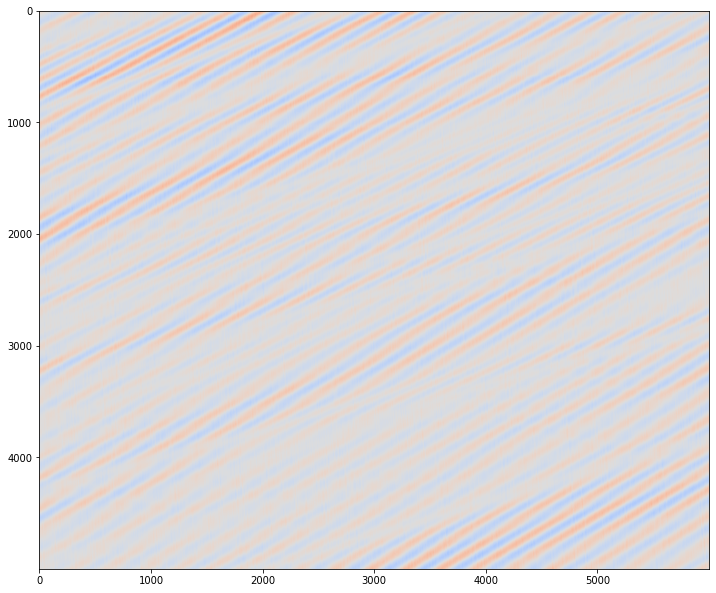

In [17]:
plt.figure(figsize=(12,12))
plt.imshow(ut ,vmin=-0.2,vmax=0.2,cmap="coolwarm")
plt.show()

### Average difference

In [2]:
def relative_error_one_file(working_dat,windw):
    scaler_val = np.std(working_dat)
    working_dat = working_dat/scaler_val
    dt=1
    dx=1
    
    ut = ps.differentiation.SmoothedFiniteDifference(d=1, axis=1,order=4,is_uniform=True,
                         drop_endpoints=True, periodic=False,smoother_kws={'window_length': windw})._differentiate(working_dat, dt)
    ux = ps.differentiation.SmoothedFiniteDifference(d=1, axis=0,order=4,is_uniform=True,
                             drop_endpoints=True, periodic=False,smoother_kws={'window_length': windw})._differentiate(working_dat, dx)
    uxx = ps.differentiation.SmoothedFiniteDifference(d=2, axis=0,order=4,is_uniform=True,
                             drop_endpoints=True, periodic=False,smoother_kws={'window_length': windw})._differentiate(working_dat, dx)
    uxxx = ps.differentiation.SmoothedFiniteDifference(d=3, axis=0,order=4,is_uniform=True,
                             drop_endpoints=True, periodic=False,smoother_kws={'window_length': windw})._differentiate(working_dat, dx)
    uxxxx = ps.differentiation.SmoothedFiniteDifference(d=4, axis=0,order=4,is_uniform=True,
                         drop_endpoints=True, periodic=False,smoother_kws={'window_length': windw})._differentiate(working_dat, dx)
    
    def err_ut(ut1, file_str):
        print("Rel. Error for "+file_str+": "+str(np.nanmean(np.abs(ut1-ut))/np.nanmean(np.abs(ut))))

    #choppy
    dudt = 0.658509 *ux + 0.368052 *uxxx
    err_ut(dudt, "unfiltered_1")
    dudt = 0.645245 *ux + 0.360646 *uxxx
    err_ut(dudt, "unfiltered_2")
    dudt = 0.648989 *ux + 0.362853 *uxxx
    err_ut(dudt, "unfiltered_3")
    dudt = 0.651448 *ux + 0.368176 *uxxx + 0.006267 *(working_dat**2)*ux + -0.003980 *(working_dat)*uxx + -0.008392 *(working_dat)*uxxx + 0.003952 *(working_dat**2)*uxxx
    err_ut(dudt, "unfiltered_4")
    
    # normalized
    dudt = 0.668423 *ux + 0.313872 *uxxx
    err_ut(dudt, "normalized_1")
    dudt = 0.680039 *ux + 0.319574 *uxxx
    err_ut(dudt, "normalized_2")
    dudt = 0.679112 *ux + 0.319926 *uxxx  -0.006064 * (working_dat**2) *ux
    err_ut(dudt, "normalized_3")
    dudt = 0.679615 *ux + 0.318684 *uxxx  -0.007691 * (working_dat**2) *ux -0.003128 * (working_dat**2) *uxxx
    err_ut(dudt, "normalized_4")
    dudt = 0.679905 *ux + -0.004579 *uxx + 0.317040 *uxxx + -0.001475 *uxxxx + 0.003089 * (working_dat) *ux + -0.006556 * (working_dat**2) *ux + -0.003064 * (working_dat**2) *uxxx
    err_ut(dudt, "normalized_5")
    
    #smoothed
    dudt = 0.996577 *ux
    err_ut(dudt, "smoothed_1")
    dudt = 0.996861 *ux + 0.122231 *uxxx
    err_ut(dudt, "smoothed_2")
    dudt =  0.997220 *ux + 0.101473 *uxxx + 0.060912 * (working_dat**2) *uxxx 
    err_ut(dudt, "smoothed_3")
    dudt = 0.997363 *ux + 0.100087 *uxxx + 0.061086 * (working_dat**2) *uxxx
    err_ut(dudt, "smoothed_4")
    dudt = 0.997344 *ux + 0.100280 *uxxx + 0.061266 *(working_dat**2) *uxxx
    err_ut(dudt, "smoothed_5")
    dudt = 0.995884 *ux + 0.098516 *uxxx + 0.001537 * (working_dat**2) *ux + 0.068080 * (working_dat**2) *uxxx
    err_ut(dudt, "smoothed_6")
    dudt = 0.995820 *ux + 0.099374 *uxxx + 0.001534 * (working_dat**2) *ux + 0.068218 * (working_dat**2) *uxxx
    err_ut(dudt, "smoothed_7")


In [61]:
path = "/data/data2/south-data-ejm/hdd/South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-01T16_09_15-0700/"

fileStr = "2021-11-01T2311_unfiltered"

init = 11
final= 16

time_subsample = 10
full_dat = np.zeros((5000,(12000//time_subsample)*(final-init)))

k = 0
for i in np.arange(init,final):
    file = "South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-01T23"+str(i)+"14Z.h5"
    f = h5py.File(path+file, 'r')
    data = f['Acquisition']['Raw[0]']['RawData'][:, :].astype('int64')
#     timestamp = f['Acquisition']['Raw[0]']['RawDataTime'][:] / 1000000
    f.close()
    
    full_dat[:,k*(12000//time_subsample):(k+1)*(12000//time_subsample)] = data[7500:12500,::time_subsample]
    k+=1
    
working_dat = full_dat/np.std(full_dat)


In [62]:
relative_error_one_file(working_dat[:,::10],40)

Rel. Error for unfiltered_1: 0.9107535015487208
Rel. Error for unfiltered_2: 0.9121726941166634
Rel. Error for unfiltered_3: 0.9117696297785587
Rel. Error for unfiltered_4: 0.9108988803004195
Rel. Error for normalized_1: 0.9101781138751864
Rel. Error for normalized_2: 0.9089755678325555
Rel. Error for normalized_3: 0.9095748688258276
Rel. Error for normalized_4: 0.909708768019967
Rel. Error for normalized_5: 0.9095840793925688
Rel. Error for smoothed_1: 0.8934868759576254
Rel. Error for smoothed_1: 0.8894126265530742
Rel. Error for smoothed_1: 0.8881977172256829
Rel. Error for smoothed_1: 0.8882250236656536
Rel. Error for smoothed_1: 0.8882160903649736
Rel. Error for smoothed_1: 0.8881213040804521
Rel. Error for smoothed_1: 0.8880975140139009


In [63]:
path = "/data/data2/south-data-ejm/hdd/South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-01T16_09_15-0700/"

fileStr = "2021-11-01T2311_unfiltered"

init = 21
final= 26

time_subsample = 10
full_dat = np.zeros((5000,(12000//time_subsample)*(final-init)))

k = 0
for i in np.arange(init,final):
    file = "South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-01T23"+str(i)+"14Z.h5"
    f = h5py.File(path+file, 'r')
    data = f['Acquisition']['Raw[0]']['RawData'][:, :].astype('int64')
#     timestamp = f['Acquisition']['Raw[0]']['RawDataTime'][:] / 1000000
    f.close()
    
    full_dat[:,k*(12000//time_subsample):(k+1)*(12000//time_subsample)] = data[7500:12500,::time_subsample]
    k+=1
    
working_dat = full_dat/np.std(full_dat)


In [64]:
relative_error_one_file(working_dat[:,::10],40)

Rel. Error for unfiltered_1: 0.9999282053377089
Rel. Error for unfiltered_2: 0.9977670727318987
Rel. Error for unfiltered_3: 0.9983630394242927
Rel. Error for unfiltered_4: 0.9997472867422411
Rel. Error for normalized_1: 1.0050283899868067
Rel. Error for normalized_2: 1.0071408300273907
Rel. Error for normalized_3: 1.0054518886551365
Rel. Error for normalized_4: 1.0054717451577218
Rel. Error for normalized_5: 1.0058784648598897
Rel. Error for smoothed_1: 1.1553263822661723
Rel. Error for smoothed_1: 1.1333705647655279
Rel. Error for smoothed_1: 1.127435688323422
Rel. Error for smoothed_1: 1.127690556084936
Rel. Error for smoothed_1: 1.1276273477403076
Rel. Error for smoothed_1: 1.1270472273810552
Rel. Error for smoothed_1: 1.1268660653016567


In [42]:
working_dat = np.load("/home/ldoyle/notebooks/channel_drift_5_min_clips/normalized_5_min_start_South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-01T231114Z.npy")[:,::10]
relative_error_one_file(working_dat,40)

Rel. Error for unfiltered_1: 0.27397578277622886
Rel. Error for unfiltered_2: 0.2658110823182509
Rel. Error for unfiltered_3: 0.26797706524421216
Rel. Error for unfiltered_4: 0.27404261881201347
Rel. Error for normalized_1: 0.28125096680848855
Rel. Error for normalized_2: 0.2902852578921456
Rel. Error for normalized_3: 0.2846155057836349
Rel. Error for normalized_4: 0.2838468282131498
Rel. Error for normalized_5: 0.28499521892848323
Rel. Error for smoothed_1: 0.7275311361235844
Rel. Error for smoothed_1: 0.7201489911718639
Rel. Error for smoothed_1: 0.7182868419571967
Rel. Error for smoothed_1: 0.7185668033070038
Rel. Error for smoothed_1: 0.7185201862488017
Rel. Error for smoothed_1: 0.7183398200636418
Rel. Error for smoothed_1: 0.7181902480910405


In [43]:
working_dat = np.load("/home/ldoyle/notebooks/channel_drift_5_min_clips/normalized_5_min_start_South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-01T232114Z.npy")[:,::10]
relative_error_one_file(working_dat,40)

Rel. Error for unfiltered_1: 0.3389918488760178
Rel. Error for unfiltered_2: 0.32925605889103354
Rel. Error for unfiltered_3: 0.33188873578131023
Rel. Error for unfiltered_4: 0.339282063515447
Rel. Error for normalized_1: 0.3473365801184493
Rel. Error for normalized_2: 0.3574399009766388
Rel. Error for normalized_3: 0.3508037413637286
Rel. Error for normalized_4: 0.34987229800244396
Rel. Error for normalized_5: 0.3512064711462565
Rel. Error for smoothed_1: 0.8054106530809104
Rel. Error for smoothed_1: 0.7968707501007939
Rel. Error for smoothed_1: 0.7950439449646757
Rel. Error for smoothed_1: 0.7953379832919217
Rel. Error for smoothed_1: 0.795289703829639
Rel. Error for smoothed_1: 0.7953537979327578
Rel. Error for smoothed_1: 0.7951959605203179


In [44]:
working_dat = np.load("/home/ldoyle/notebooks/channel_drift_5_min_clips/normalized_5_min_start_South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-02T051114Z.npy")[:,::10]
relative_error_one_file(working_dat,40)

Rel. Error for unfiltered_1: 0.3500078196535552
Rel. Error for unfiltered_2: 0.3396138843558109
Rel. Error for unfiltered_3: 0.3424329755846198
Rel. Error for unfiltered_4: 0.35004408028156336
Rel. Error for normalized_1: 0.3588095438685149
Rel. Error for normalized_2: 0.3694697488831427
Rel. Error for normalized_3: 0.3628366426391596
Rel. Error for normalized_4: 0.36196800932128254
Rel. Error for normalized_5: 0.36325560537507795
Rel. Error for smoothed_1: 0.8274868540636289
Rel. Error for smoothed_1: 0.819769780003164
Rel. Error for smoothed_1: 0.8181325137219502
Rel. Error for smoothed_1: 0.8184242631103351
Rel. Error for smoothed_1: 0.8183780302564444
Rel. Error for smoothed_1: 0.8185125064937205
Rel. Error for smoothed_1: 0.8183587667858662


In [3]:
working_dat = np.load("/home/ldoyle/notebooks/channel_drift_5_min_clips/normalized_5_min_start_South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-02T231114Z.npy")[:,::10]
relative_error_one_file(working_dat,40)

Rel. Error for unfiltered_1: 0.5136166717785615
Rel. Error for unfiltered_2: 0.5013072418241138
Rel. Error for unfiltered_3: 0.5047047587255838
Rel. Error for unfiltered_4: 0.5140564629486434
Rel. Error for normalized_1: 0.5236548838981055
Rel. Error for normalized_2: 0.5355072240043537
Rel. Error for normalized_3: 0.5274859679653056
Rel. Error for normalized_4: 0.5262832210918976
Rel. Error for normalized_5: 0.5279006358732841
Rel. Error for smoothed_1: 1.0087737258260243
Rel. Error for smoothed_2: 0.9962777513567037
Rel. Error for smoothed_3: 0.9934023625364548
Rel. Error for smoothed_4: 0.9937336537778396
Rel. Error for smoothed_5: 0.9936772700960746
Rel. Error for smoothed_6: 0.993794097025912
Rel. Error for smoothed_7: 0.9936112985628485


In [57]:
working_dat = np.load("/home/ldoyle/notebooks/channel_drift_5_min_clips/rad_4_smoothed_decimated_normalized_5_min_start_South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-01T231114Z.npy")
relative_error_one_file(working_dat,40)

Rel. Error for unfiltered_1: 0.23563069699166073
Rel. Error for unfiltered_2: 0.22786293359396634
Rel. Error for unfiltered_3: 0.22989185615785424
Rel. Error for unfiltered_4: 0.23562464737448224
Rel. Error for normalized_1: 0.24265120311175656
Rel. Error for normalized_2: 0.2516418404863023
Rel. Error for normalized_3: 0.24611145707081805
Rel. Error for normalized_4: 0.2453347394648564
Rel. Error for normalized_5: 0.24642918035349973
Rel. Error for smoothed_1: 0.6790965639595932
Rel. Error for smoothed_1: 0.679190112964655
Rel. Error for smoothed_1: 0.6795821578617216
Rel. Error for smoothed_1: 0.6798078458027838
Rel. Error for smoothed_1: 0.6797770613540228
Rel. Error for smoothed_1: 0.6797611076958224
Rel. Error for smoothed_1: 0.6796540864990218


In [56]:
working_dat = np.load("/home/ldoyle/notebooks/channel_drift_5_min_clips/rad_4_smoothed_decimated_normalized_5_min_start_South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-01T232114Z.npy")
relative_error_one_file(working_dat,40)

Rel. Error for unfiltered_1: 0.3034636306637415
Rel. Error for unfiltered_2: 0.29414801852775707
Rel. Error for unfiltered_3: 0.29664638789051595
Rel. Error for unfiltered_4: 0.30371529077951986
Rel. Error for normalized_1: 0.31144807504516697
Rel. Error for normalized_2: 0.3213673156752386
Rel. Error for normalized_3: 0.3149270974183807
Rel. Error for normalized_4: 0.3139854705047339
Rel. Error for normalized_5: 0.315252605093113
Rel. Error for smoothed_1: 0.7507231038807731
Rel. Error for smoothed_1: 0.7507354215522991
Rel. Error for smoothed_1: 0.7511030573386184
Rel. Error for smoothed_1: 0.7513301885020379
Rel. Error for smoothed_1: 0.7512990932197215
Rel. Error for smoothed_1: 0.7515101483019955
Rel. Error for smoothed_1: 0.7514017811655016


In [59]:
working_dat = np.load("/home/ldoyle/notebooks/channel_drift_5_min_clips/rad_4_smoothed_decimated_normalized_5_min_start_South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-02T051114Z.npy")
relative_error_one_file(working_dat,40)

Rel. Error for unfiltered_1: 0.31630734579233843
Rel. Error for unfiltered_2: 0.30623855927065347
Rel. Error for unfiltered_3: 0.3089509109562731
Rel. Error for unfiltered_4: 0.3162503082096652
Rel. Error for normalized_1: 0.3248289481651987
Rel. Error for normalized_2: 0.33538448154633876
Rel. Error for normalized_3: 0.32894243977032667
Rel. Error for normalized_4: 0.3280810720246803
Rel. Error for normalized_5: 0.3293003269534729
Rel. Error for smoothed_1: 0.7776349323939908
Rel. Error for smoothed_1: 0.777728898631371
Rel. Error for smoothed_1: 0.7781108357187787
Rel. Error for smoothed_1: 0.7783419390224862
Rel. Error for smoothed_1: 0.7783103438666473
Rel. Error for smoothed_1: 0.7785587005746558
Rel. Error for smoothed_1: 0.7784484586689777


In [60]:
working_dat = np.load("/home/ldoyle/notebooks/channel_drift_5_min_clips/rad_4_smoothed_decimated_normalized_5_min_start_South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-02T231114Z.npy")
relative_error_one_file(working_dat,40)

Rel. Error for unfiltered_1: 0.4727485635239706
Rel. Error for unfiltered_2: 0.46118164257234706
Rel. Error for unfiltered_3: 0.464361392989958
Rel. Error for unfiltered_4: 0.47306056775185734
Rel. Error for normalized_1: 0.48221974552164865
Rel. Error for normalized_2: 0.4935162757292279
Rel. Error for normalized_3: 0.48597942023866
Rel. Error for normalized_4: 0.48481381545837093
Rel. Error for normalized_5: 0.48631246239521453
Rel. Error for smoothed_1: 0.9298859735495689
Rel. Error for smoothed_1: 0.9296671478781189
Rel. Error for smoothed_1: 0.9299355270276503
Rel. Error for smoothed_1: 0.9301676017979669
Rel. Error for smoothed_1: 0.9301353451298067
Rel. Error for smoothed_1: 0.9304248147303061
Rel. Error for smoothed_1: 0.9303130329414327
